## Repositório

[Tópicos Avançados em Inteligência Computacional 2](https://github.com/Manuelfjr/topicos_avancados_ic_ii/tree/develop)

## Atividade 04

**[Feature Importance]**

descrição:

1. Leia os slides sobre Feature Importance e as páginas 154 e 162 do livro do Molnar.

2. Construa um modelo de classificação para um conjunto do seu interesse e compute PFI para cada classe. Vc pode separar o conjunto de exemplos de teste por classe e executar o PFI duas vezes (uma vez para cada subconjunto de teste separado) e verificar as diferenças entre as variáveis consideradas importantes para cada classe.

## Introdução

informações: 
A base utilizada será a mesma da atividade `01`.

* **dataset**:  Breast cancer wisconsin (diagnostic)

* **Attribute Information**:
    - radius (mean of distances from center to points on the perimeter)

    - texture (standard deviation of gray-scale values)

    - perimeter

    - area

    - smoothness (local variation in radius lengths)

    - compactness (perimeter^2 / area - 1.0)

    - concavity (severity of concave portions of the contour)

    - concave points (number of concave portions of the contour)

    - symmetry

    - fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

* **class**:
    - WDBC-Malignant (1)
    - WDBC-Benign (0)

## Descrição

Para essa atividade, será selecionado a base de dados da atividade `01` e o melhor modelo utilizado também na atividade `01`, sendo o modelo *Random Forest*.

## Objetivo

Ajustar um modelo para abase de dados *breast cancer*, avaliar desempenho e verificar o *Feature Importance* por classe.

## 0. Basics

### 0.1 Imports

In [1]:
# datasets
# utils
import warnings
from typing import Any, Dict, List, Tuple, Union

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, make_scorer,
                             precision_score, recall_score, roc_auc_score)
# metrics
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm

warnings.filterwarnings('ignore')

### 0.2 Methods

In [2]:
def generate_color_range(
        color1_name: str,
        color2_name: str,
        num_colors: int
) -> List[Tuple[int, int, int]]:
    """
    Gera uma lista de cores intermediárias entre duas cores fornecidas.

    Parâmetros:
        color1_name (str): Nome da primeira cor.
        color2_name (str): Nome da segunda cor.
        num_colors (int): Número de cores intermediárias a serem geradas.

    Retorna:
        List[Tuple[int, int, int]]: Uma lista de tuplas representando as cores intermediárias no formato (R, G, B).
    """
    # Converter nomes de cores em valores RGB
    color1_rgb = mcolors.to_rgb(color1_name)
    color2_rgb = mcolors.to_rgb(color2_name)

    # Gerar a lista de cores intermediárias
    color_range = []
    for i in range(num_colors):
        ratio = i / (num_colors - 1)
        r = int(color1_rgb[0] * (1 - ratio) + color2_rgb[0] * ratio)
        g = int(color1_rgb[1] * (1 - ratio) + color2_rgb[1] * ratio)
        b = int(color1_rgb[2] * (1 - ratio) + color2_rgb[2] * ratio)
        color_range.append((r, g, b))

    return color_range


def calculate_metrics(
        model: Any,
        X: Union[pd.DataFrame, pd.Series, np.ndarray],
        y: Union[pd.DataFrame, pd.Series, np.ndarray],
        features: Union[list, np.ndarray],
        which_metrics: Dict[str, Any] = {"accuracy_score": accuracy_score},
        cv: int = 5,
) -> pd.DataFrame:

    """
    Calcula as métricas especificadas usando validação cruzada e retorna um DataFrame.

    Parâmetros:
        model (estimator): O modelo de aprendizado de máquina a ser avaliado.
        X (array-like): As features do conjunto de dados.
        y (array-like): Os rótulos do conjunto de dados.
        cv (int ou iterável): O esquema de validação cruzada a ser utilizado.
        which_metrics (dict): Um dicionário onde as chaves são os nomes das
                                métricas e os valores são as funções de métrica.

    Retorna:
        pd.DataFrame: Um DataFrame contendo as métricas calculadas.

    Exemplo:
        metrics = {
            'accuracy': accuracy_score,
            'precision': precision_score,
            'recall': recall_score
        }
        results = calculate_metrics(model, X, y, cv=5, which_metrics=metrics)
    """
    metrics = {}
    for m, metric in tqdm(which_metrics.items(), desc="Cros-validation"):
        metric = make_scorer(metric)
        value = [float(np.mean(cross_val_score(model, X[features], y, cv=cv, scoring=metric)))]
        metrics[m] = value

    if len(features) == X.shape[1]:
        index_name = ["all_features"]
    else:
        index_name = ["partial_features"]

    results = pd.DataFrame(metrics, index=index_name)
    return results


def plot_bar_chart(
        groups: pd.DataFrame,
        ordered_features: List[str],
        colors: List[str],
        figsize: tuple = (16, 6),
        bar_width: float = 0.35,
        rotation: Union[int, float] = 90,
        **kwargs: Any
) -> tuple:
    """
    Plota um gráfico de barras a partir dos dados fornecidos.

    Parâmetros:
        groups (DataFrame): Os dados a serem plotados.
        ordered_features (list): Lista das características ordenadas.
        colors (list): Lista de cores para cada grupo.
        **kwargs: Argumentos adicionais a serem passados para a função de barra.

    Retorna:
        plt.Figure: A figura do gráfico de barras plotado.
    """
    fig_bar, ax_bar = plt.subplots(1, 1, figsize=figsize)
    index = np.arange(len(groups.index))
    for i, label in enumerate(groups.columns.levels[1]):
        ax_bar.bar(
            index + i * bar_width,
            groups.loc[ordered_features, ('importances_mean', label)],
            yerr=groups.loc[ordered_features, ('importances_std', label)],
            width=bar_width,
            label=label,
            color=colors[i],
            alpha=0.6,
            **kwargs
        )

    ax_bar.set_ylabel('Importancia Média')
    ax_bar.set_title('Importancia das Features por classe. (n_features = {})'.format(len(ordered_features)))
    ax_bar.set_xticks(index + bar_width / 2)
    ax_bar.set_xticklabels(ordered_features, rotation=rotation)
    ax_bar.legend(loc="best")
    ax_bar.grid()
    fig_bar.tight_layout()
    plt.close()
    return fig_bar, ax_bar


def plot_heatmap(
        groups: pd.DataFrame,
        y: np.ndarray,
        figsize: tuple = (18, 8),
        **kwargs: Any
) -> tuple:
    """
    Plota um heatmap a partir dos dados fornecidos.

    Parâmetros:
        groups (DataFrame): Os dados a serem plotados.
        y (ndarray): O array de rótulos.
        axes_hm (Axes): O objeto de eixo do heatmap.
        **kwargs: Argumentos adicionais a serem passados para a função de heatmap.

    Retorna:
        None
    """
    fig_hm, axes_hm = plt.subplots(1, 1, figsize=figsize)

    sns.heatmap(groups.iloc[:, np.unique(y)], annot=True, ax=axes_hm, **kwargs)
    axes_hm.set(xlabel="")
    axes_hm.set_title("Feature Permutation Importance por classe. (n_features = {})".format(groups.shape[0]))
    plt.tight_layout()
    plt.close()
    return fig_hm, axes_hm

### 0.3 Parameters

In [3]:
n_seed = 24
n_seed_pfi = 42
cv = 10
n_repeats = 30

In [4]:
params = {
    "holdout": {
        "test_size": 0.3,
        "random_state": 2024
    }
}

In [5]:
which_metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
    "roc_auc": roc_auc_score
}

In [6]:
lower_color_name = 'blue'
upper_color_name = 'red'

## 1. Preparando dataset

### 1.1 Leitura

In [7]:
target = "label"
content = load_breast_cancer()
features = list(content["feature_names"])

### 1.2 Process dataset

In [8]:
data = pd.DataFrame(
    content["data"],
    columns=features
)
data[target] = content["target"]
data.columns = (
    data
    .columns
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

### 1.3 Split

In [9]:
X = data.drop(target, axis=1).copy()
y = data[target].values

### 1.4 Holdout

aplicação do processo de holdout, considerando um tamanho de teste de `30%`

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    **params["holdout"]
)

## 2. Modelagem

### 2.1 Fit 

In [11]:
model = RandomForestClassifier(random_state=n_seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

### 2.2 Avaliando

In [12]:
full_model_metrics = calculate_metrics(model, X, y, X.columns, which_metrics=which_metrics, cv=cv)
full_model_metrics

Cros-validation: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


,accuracy,precision,recall,f1,roc_auc
all_features,0.97193,0.9734,0.983175,0.977884,0.968211


## 3. Permutation Feature Importance (PFI)

### 3.1 Full model

In [13]:
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=n_repeats,
    random_state=n_seed_pfi
)
sorted_idx = result.importances_mean.argsort()
del result["importances"]
result["features"] = X_test.columns
data_result = pd.DataFrame(result).set_index(["features"]).sort_values("importances_mean")

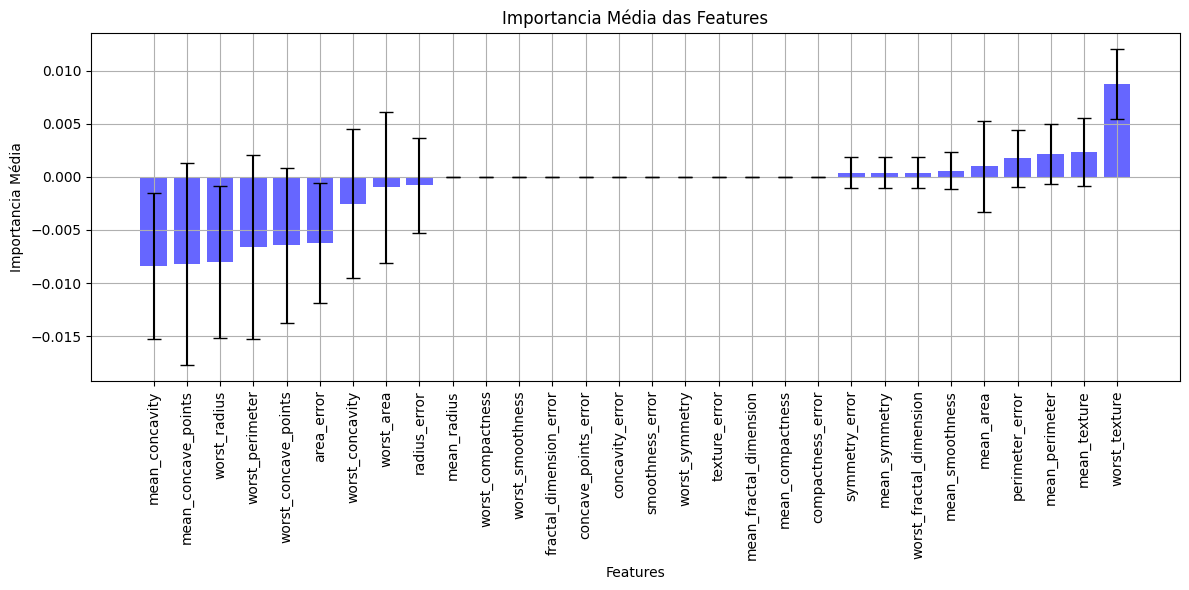

In [14]:
# Plotagem do gráfico de barras
fig_full, axes_full = plt.subplots(1, 1, figsize=(12, 6))
axes_full.bar(
    data_result.index,
    data_result['importances_mean'],
    color='blue',
    alpha=0.6,
    yerr=data_result['importances_std'],
    capsize=5
)
axes_full.set_xlabel('Features')
axes_full.set_ylabel('Importancia Média')
axes_full.set_title('Importancia Média das Features')
axes_full.set_xticklabels(data_result.index, rotation=90)
fig_full.tight_layout()
axes_full.grid()
plt.show()

### 3.2 Por classe

Abaixo será separado o conjunto de teste pelas classes, para o calculo do *PFI*.

In [15]:
model = RandomForestClassifier(random_state=n_seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

In [16]:
results = {}
for class_label in tqdm(np.unique(y_test)):
    X_test_class = X_test[y_test == class_label]
    y_test_class = y_test[y_test == class_label]

    result = permutation_importance(
        model,
        X_test_class,
        y_test_class,
        n_repeats=n_repeats,
        random_state=n_seed_pfi
    )
    sorted_idx = result.importances_mean.argsort()
    del result["importances"]
    result["features"] = X_test.columns
    result["label"] = [f"class_{class_label}"] * X_test.shape[1]
    results[f"c{class_label}"] = pd.DataFrame(result).set_index(["label", "features"])
data_result = pd.concat(list(results.values())).reset_index()

100%|██████████| 2/2 [00:13<00:00,  6.62s/it]


### 3.3 Analise


Ao analisar a importância das características no modelo observamos uma variação significativa na *importance* de cada *feature* para o modelo. Considerando primeiramente o modelo completo, notamos que algumas *features* têm uma influência considerável, enquanto outras têm importância praticamente nula. Uma analise interessante seria das *features*  *mean_concavity*, *mean_concave_points* e *worst_radius* que tiveram uma importância negativa, evidenciando que essas features perturbando aleatoriamente as instancias, apresentaram metricas maiores que o modelo completo. Já olhando para a *feature* *worst_texture*, que possui uma importância positiva relativamente alta, indicando uma associação positiva com a classificação postiva, que seria o cancer maligno.

## 4. Gráficos

### 4.1 Visualização

In [17]:
num_colors = len(np.unique(y))

In [18]:
color_sequence = generate_color_range(
    lower_color_name,
    upper_color_name,
    num_colors
)

In [19]:
groups = data_result.groupby(['features', 'label']).mean().unstack()
ci_mean_importances = groups['importances_mean']['class_0']
ordered_features_full = ci_mean_importances.sort_values().index.tolist()

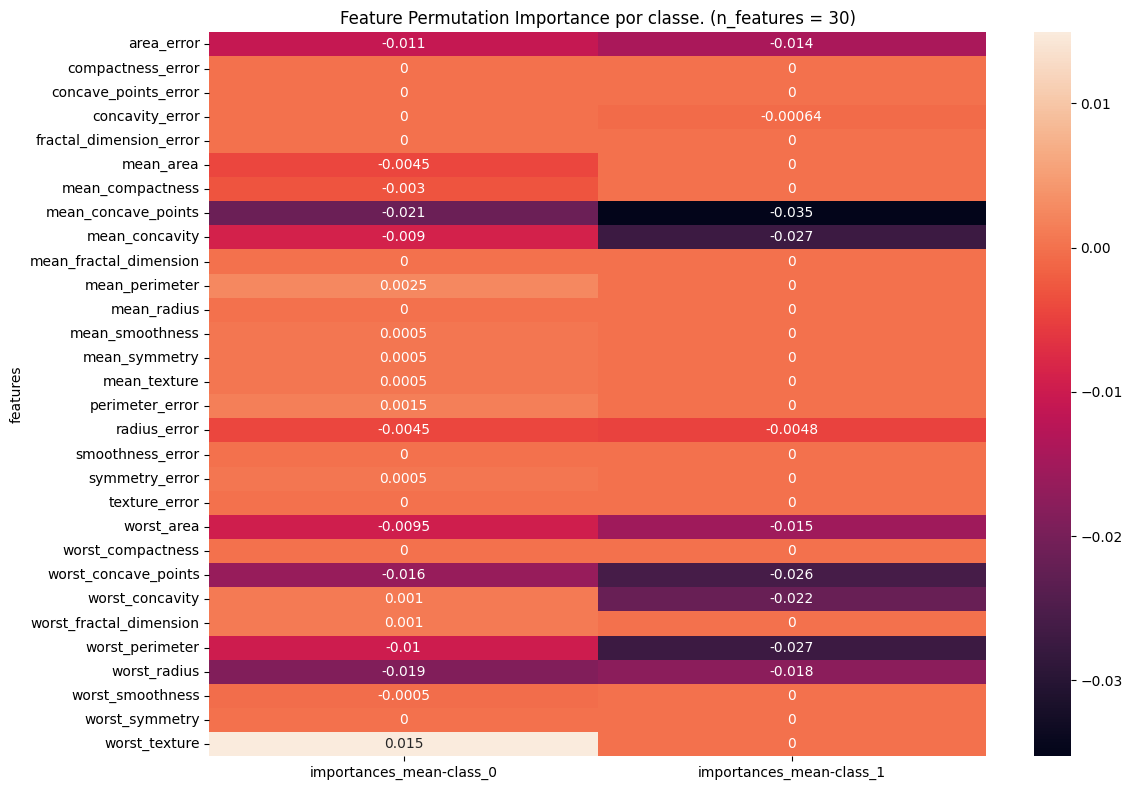

In [20]:
fig_hm, _ = plot_heatmap(
    groups,
    y,
    figsize=(12, 8)
)
fig_hm

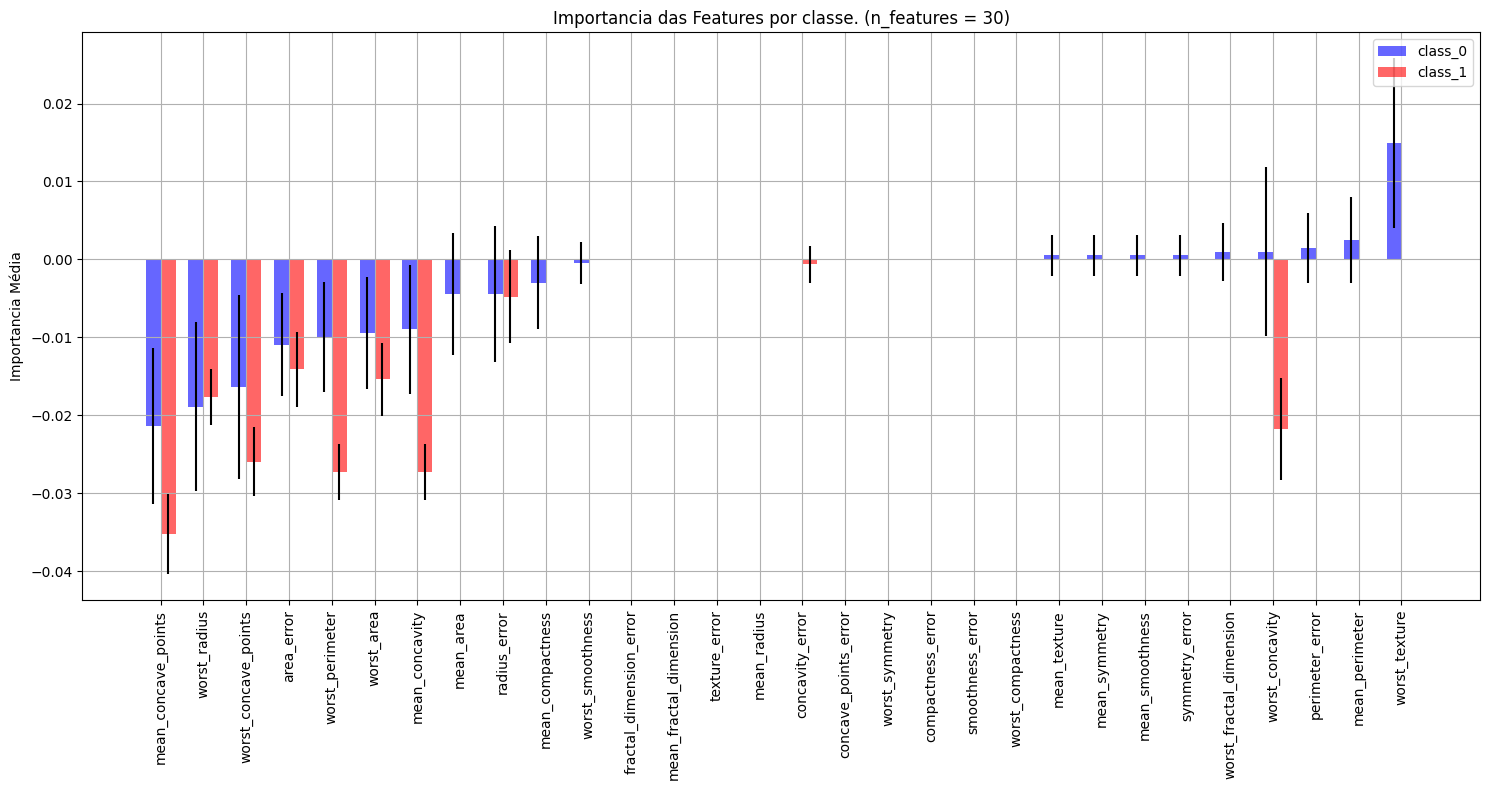

In [21]:
fig_bar, _ = plot_bar_chart(
    groups,
    ordered_features_full,
    color_sequence,
    figsize=(15, 8)
)
fig_bar

### 4.2 Analise

Algumas *features* apresentaram importância negativa tanto para a classe 0 (câncer benigno) quanto para a classe 1 (câncer maligno). Isso sugere que a essa *features*, ao serem perturbadas aleatoriamente, apresenta-se um aumento da metrica avaliada pelo *PFI*. 

Além disso, outras *features* têm importância negativa mais forte para uma das classes em comparação com a outra. Por exemplo, *mean_concave_points* e *worst_concave_points* têm importância negativa tanto para a classe 0 quanto para a classe 1, mas apresentam valores mais baixos para a classe 1.

Por fim, podemos observar que algumas *features* têm importância positiva para uma das classes, sendo ela a *feature* *worst_texture* tem importância positiva para a classe 0, o que indica que sua presença está associada a um aumento na probabilidade de classificação da classe positiva. No entanto, essa mesma *feature* não tem influência na classificação da classe 1.

## 5. Retirando variaveis com importancia zero para ambas classes

In [22]:
importances_mean = groups.iloc[:, :(len(np.unique(y)) * 2)].copy()

feature_imp_non_zero = importances_mean[
    ~importances_mean.iloc[:, :len(np.unique(y))].filter(like="class_").eq(0).all(axis=1)
].copy()

ci_mean_importances = feature_imp_non_zero['importances_mean']['class_0']
ordered_features_partial = ci_mean_importances.sort_values().index.tolist()

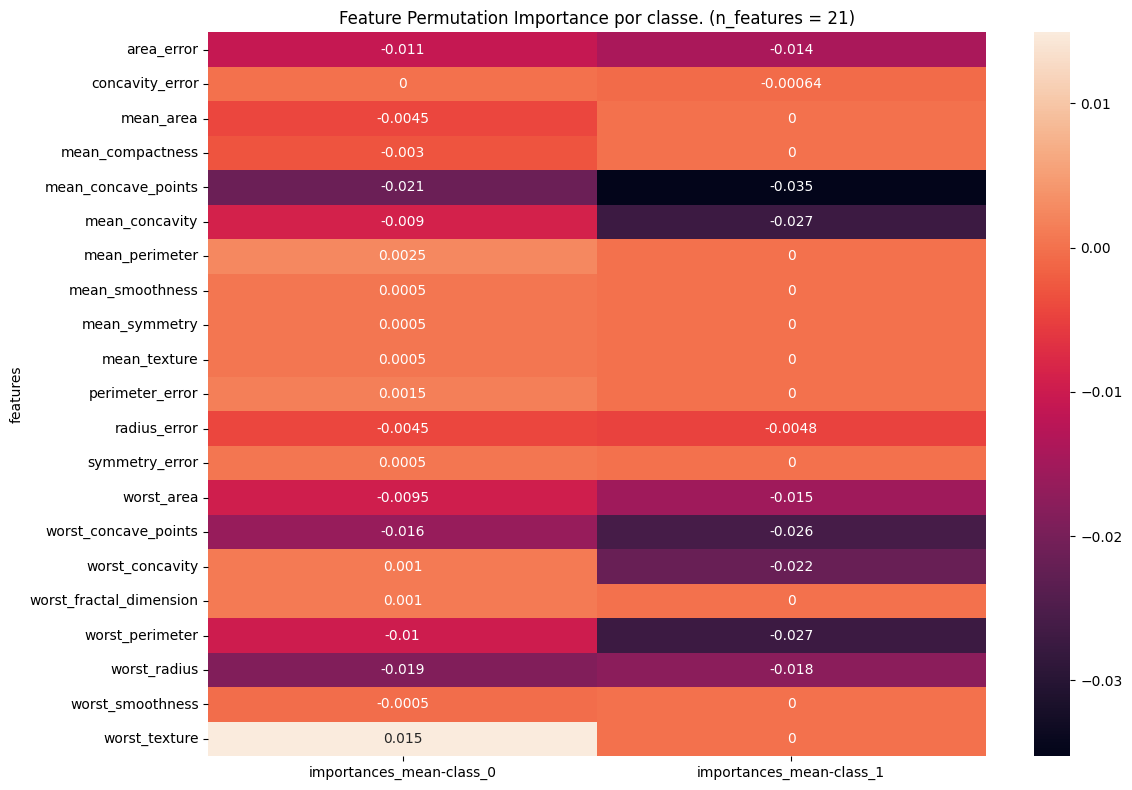

In [23]:
fig_hm_non, _ = plot_heatmap(feature_imp_non_zero, y, figsize=(12, 8))
fig_hm_non

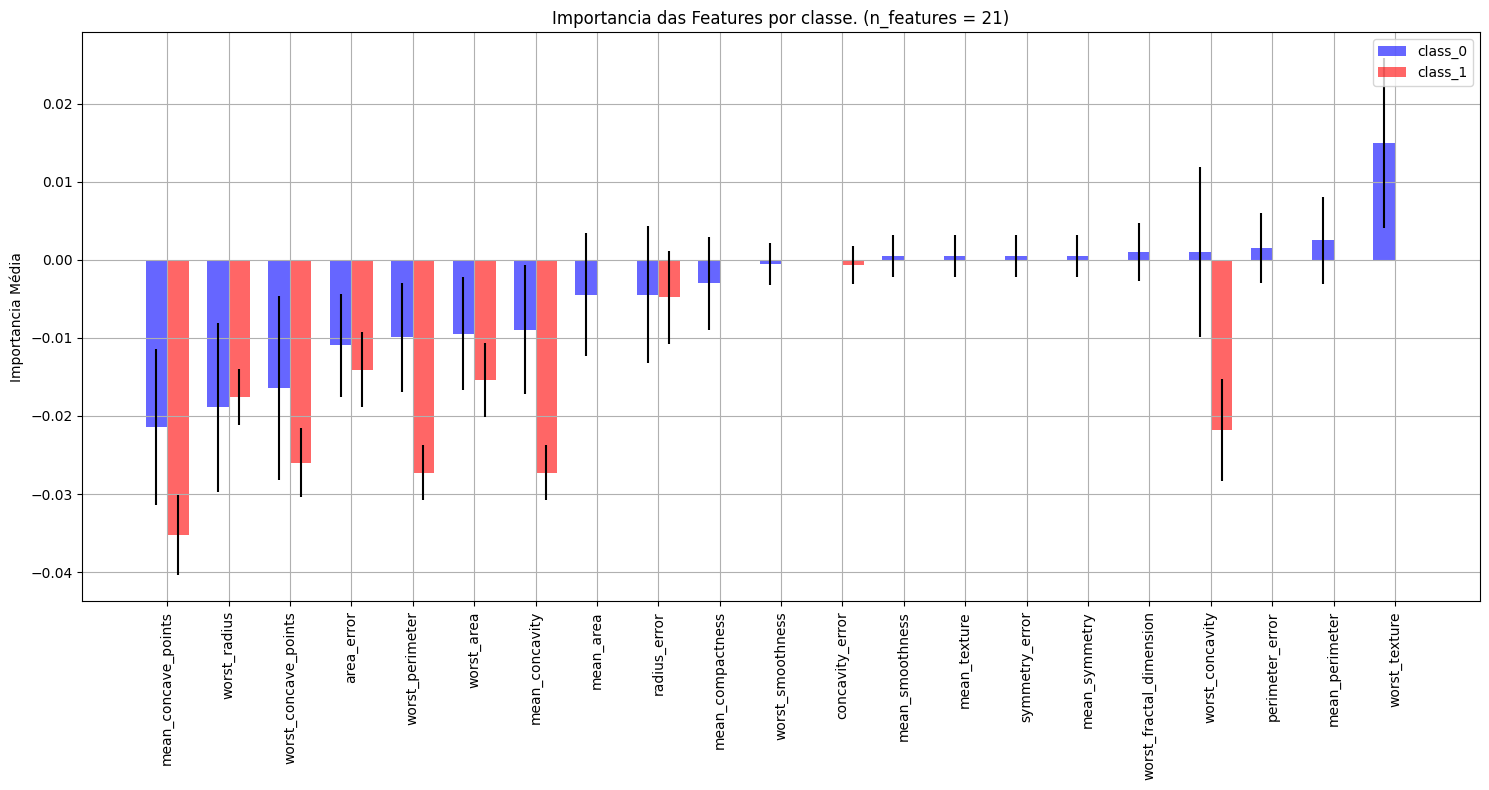

In [24]:
fig_bar_partial, _ = plot_bar_chart(
    feature_imp_non_zero,
    ordered_features_partial,
    color_sequence,
    figsize=(15, 8)
)
fig_bar_partial

## 6. Re-treinando modelo com apenas features com importance ambos diferente de zero

### 6.1 Fit

In [25]:
model = RandomForestClassifier(random_state=n_seed)
model.fit(X_train[feature_imp_non_zero.index], y_train)

RandomForestClassifier(random_state=24)

### 6.2 Avaliação

In [26]:
partial_model_metrics = calculate_metrics(
    model,
    X,
    y,
    feature_imp_non_zero.index,
    which_metrics=which_metrics,
    cv=cv
)
partial_model_metrics

Cros-validation: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


,accuracy,precision,recall,f1,roc_auc
partial_features,0.966667,0.967829,0.980317,0.973734,0.96202


In [27]:
results = pd.concat([full_model_metrics, partial_model_metrics]).T

In [28]:
results

,all_features,partial_features
accuracy,0.971930,0.966667
precision,0.973400,0.967829
recall,0.983175,0.980317
f1,0.977884,0.973734
roc_auc,0.968211,0.962020


## 7. Conclusões

|            | **all_features** | **partial_features** |
|------------|--------------|------------------|
| **accuracy**   |   0.971930   |      0.966667    |
| **precision**  |   0.973400   |      0.967829    |
| **recall**     |   0.983175   |      0.980317    |
| **f1**         |   0.977884   |      0.973734    |
| **roc_auc**    |   0.968211   |      0.962020    |


Após analisar os resultados das validações cruzadas para o modelo utilizando todas as variáveis (*full_features*) em comparação com o modelo utilizando apenas as características diferentes de zero (*partial_features*), podemos observar que ambos os modelos apresentam desempenho bastante semelhante em termos de métricas de avaliação, como *accuracy*, *precision*, *recall*, *f1* e *roc_auc*.

Isso sugere uma notável robustez do modelo, mesmo após a retirada das *features* que têm importância zero para ambas as classes. O modelo com menos variáveis, que utiliza apenas as que posssuem relevância para a classificação, segundo o *PFI*, mantém um desempenho praticamente igual ao modelo completo. Essa consistência no desempenho indica que as *features* removidas não contribuem significativamente para a capacidade do modelo de fazer previsões precisas.

Portanto, a capacidade do modelo de manter um desempenho elevado mesmo após a remoção de *features* com baixa importância ressalta sua robustez e capacidade de generalização. Essa característica é crucial em situações onde a simplificação do modelo pode ser desejável, seja para reduzir a complexidade, melhorar a interpretabilidade ou aumentar a eficiência computacional, sem comprometer sua precisão.

Além disso, apesar do modelo ainda manter uma boa performance apos a retirada das variáveis, ainda houve uma queda das metricas, isso evidencia também que existia alguma relação intrisica das variaveis que foram retiradas para com o target, havendo alguma importância que o método *Permutation Feature Importance* conseguiu mensurar na sua forma de estimação.